<a href="https://colab.research.google.com/github/sayakpaul/Training-BatchNorm-and-Only-BatchNorm/blob/master/CIFAR10_Full_TPU_Different_LR_Schedules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Authenticate yourself to use the TPUs
import os

IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()

In [0]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


In [0]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.109.199.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.109.199.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.109.199.10:8470']
Number of accelerators:  8


In [0]:
!pip install wandb -q
import wandb
wandb.login()

In [0]:
!wget https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py

In [0]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import tensorflow as tf
import resnet_cifar10
import numpy as np
import time

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [0]:
def get_training_model(optimizer="sgd"):
    # ResNet20
    n = 2
    depth =  n * 9 + 2
    n_blocks = ((depth - 2) // 9) - 1

    # The input tensor
    inputs = Input(shape=(32, 32, 3))

    # The Stem Convolution Group
    x = resnet_cifar10.stem(inputs)

    # The learner
    x = resnet_cifar10.learner(x, n_blocks)

    # The Classifier for 10 classes
    outputs = resnet_cifar10.classifier(x, 10)

    # Instantiate the Model
    model = Model(inputs, outputs)

    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [0]:
# Load the training set of CIFAR10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [0]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync

def normalize(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

def augment(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)

    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [0]:
with strategy.scope():
    model = get_training_model()
model.summary()

- Total params: 575,114
- **Trainable params: 571,114**
- Non-trainable params: 4,000


In [0]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

In [0]:
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

1e-05 0.00016974400000000002


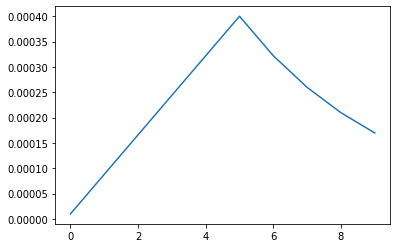

In [0]:
rng = [i for i in range(10)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [0]:
# Train model with adam
wandb.init(project="training-bn-only", id="resnet-adam")

with strategy.scope():
    model = get_training_model("adam")
    
start = time.time()
h = model.fit(train_ds,
         validation_data=test_ds,
         epochs=75,
         callbacks=[WandbCallback()])
end = time.time()
wandb.log({"training_time": end - start})
print("Network takes {:.3f} seconds to train".format(end - start))

Epoch 1/75
49/49 [==============================] - 12s 250ms/step - accuracy: 0.3086 - loss: 1.8823 - val_accuracy: 0.1391 - val_loss: 2.4941
Epoch 2/75
49/49 [==============================] - 5s 110ms/step - accuracy: 0.4289 - loss: 1.5597 - val_accuracy: 0.2024 - val_loss: 2.4139
Epoch 3/75
49/49 [==============================] - 5s 109ms/step - accuracy: 0.4995 - loss: 1.3862 - val_accuracy: 0.2564 - val_loss: 2.1664
Epoch 4/75
49/49 [==============================] - 5s 107ms/step - accuracy: 0.5483 - loss: 1.2612 - val_accuracy: 0.3827 - val_loss: 1.7452
Epoch 5/75
49/49 [==============================] - 7s 147ms/step - accuracy: 0.5870 - loss: 1.1616 - val_accuracy: 0.3760 - val_loss: 1.8512
Epoch 6/75
49/49 [==============================] - 5s 110ms/step - accuracy: 0.6149 - loss: 1.0844 - val_accuracy: 0.4477 - val_loss: 1.6076
Epoch 7/75
49/49 [==============================] - 5s 109ms/step - accuracy: 0.6372 - loss: 1.0229 - val_accuracy: 0.5343 - val_loss: 1.3327
Epoch

In [0]:
# Train model with adam
wandb.init(project="training-bn-only", id="resnet-adam-rampup")

with strategy.scope():
    model = get_training_model("adam")
    
start = time.time()
h = model.fit(train_ds,
         validation_data=test_ds,
         epochs=75,
         callbacks=[WandbCallback(), lr_callback])
end = time.time()
wandb.log({"training_time": end - start})
print("Network takes {:.3f} seconds to train".format(end - start))


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/75
49/49 [==============================] - 12s 249ms/step - accuracy: 0.1112 - loss: 2.4351 - val_accuracy: 0.1164 - val_loss: 2.3487 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/75
49/49 [==============================] - 5s 108ms/step - accuracy: 0.1759 - loss: 2.2261 - val_accuracy: 0.1209 - val_loss: 2.2865 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/75
49/49 [==============================] - 4s 89ms/step - accuracy: 0.2772 - loss: 1.9760 - val_accuracy: 0.1536 - val_loss: 2.3793 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/75
49/49 [==============================] - 4s 88ms/step - accuracy: 0.3376 - loss: 1.7987 - val_accuracy: 0.1986 - val_loss: 2.3158 - lr: 2.4400e-04

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/7

In [0]:
with strategy.scope():
    model = get_training_model("adam")

    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            if hasattr(layer, "trainable"):
                layer.trainable=False
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
model.summary()

- Total params: 575,114
- **Trainable params: 4,000**
- Non-trainable params: 571,114

In [0]:
wandb.init(project="training-bn-only", id="bn-only-adam")

start = time.time()
h = model.fit(train_ds,
         validation_data=test_ds,
         epochs=75,
         callbacks=[WandbCallback()])
end = time.time()
wandb.log({"training_time": end - start})
print("Network takes {:.3f} seconds to train".format(end - start))

Epoch 1/75
49/49 [==============================] - 10s 207ms/step - accuracy: 0.1013 - loss: 2.5196 - val_accuracy: 0.1343 - val_loss: 2.3357
Epoch 2/75
49/49 [==============================] - 5s 98ms/step - accuracy: 0.1183 - loss: 2.3591 - val_accuracy: 0.1043 - val_loss: 2.2880
Epoch 3/75
49/49 [==============================] - 5s 97ms/step - accuracy: 0.1521 - loss: 2.2691 - val_accuracy: 0.1215 - val_loss: 2.2841
Epoch 4/75
49/49 [==============================] - 5s 97ms/step - accuracy: 0.1839 - loss: 2.2053 - val_accuracy: 0.1331 - val_loss: 2.2559
Epoch 5/75
49/49 [==============================] - 5s 98ms/step - accuracy: 0.2098 - loss: 2.1544 - val_accuracy: 0.1649 - val_loss: 2.1920
Epoch 6/75
49/49 [==============================] - 5s 96ms/step - accuracy: 0.2328 - loss: 2.1028 - val_accuracy: 0.1922 - val_loss: 2.1286
Epoch 7/75
49/49 [==============================] - 5s 95ms/step - accuracy: 0.2413 - loss: 2.0627 - val_accuracy: 0.2072 - val_loss: 2.0762
Epoch 8/75


In [0]:
model.save_weights("resnet_bn_only_adam.h5")
!gsutil -m cp -r resnet_bn_only_adam.h5 gs://batch_norm_tpu/

In [0]:
# Train model with a decay schedule
wandb.init(project="training-bn-only", id="bn-only-adam-ramups")

with strategy.scope():
    model = get_training_model("adam")

    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            if hasattr(layer, "trainable"):
                layer.trainable=False
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
start = time.time()
h = model.fit(train_ds,
         validation_data=test_ds,
         epochs=75,
         callbacks=[WandbCallback(), lr_callback])
end = time.time()
wandb.log({"training_time": end - start})
print("Network takes {:.3f} seconds to train".format(end - start))


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/75
49/49 [==============================] - 10s 208ms/step - accuracy: 0.0909 - loss: 2.3637 - val_accuracy: 0.0738 - val_loss: 2.3711 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/75
49/49 [==============================] - 5s 98ms/step - accuracy: 0.0914 - loss: 2.3580 - val_accuracy: 0.0945 - val_loss: 2.3008 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/75
49/49 [==============================] - 5s 97ms/step - accuracy: 0.0960 - loss: 2.3415 - val_accuracy: 0.1016 - val_loss: 2.2984 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/75
49/49 [==============================] - 5s 98ms/step - accuracy: 0.1089 - loss: 2.3184 - val_accuracy: 0.1156 - val_loss: 2.2935 - lr: 2.4400e-04

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
Epoch 5/75

In [0]:
model.save_weights("resnet_bn_rampup_adam.h5")
!gsutil -m cp -r resnet_bn_rampup_adam.h5 gs://batch_norm_tpu/

Copying file://resnet_bn_rampup_adam.h5 [Content-Type=application/octet-stream]...
/ [1/1 files][  2.4 MiB/  2.4 MiB] 100% Done                                    
Operation completed over 1 objects/2.4 MiB.                                      
